In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

## Data Cleaning

In [2]:
# Remove #ERRORS subject lines
df = pd.read_csv('raw_master.csv', names=['subject', 'from', 'date', 'to', 'label', 'thread'])
df = df[~df['subject'].astype(str).str.startswith("#")]
df = df[~df['from'].astype(str).str.startswith("#")]
df.head()

,subject,from,date,to,label,thread
0,subject,Sender,Date,To,Category,Thread
1,Event for Freshmen: Discover career opportunit...,"""RippleMatch"" <katebeckman@ripplematch.com>","Mon, 22 Feb 2021 20:11:34 +0000 (UTC)",tanishkumar@berkeley.edu,"Inbox,Important,Category Promotions,Unread",1692427563481259075
6,Complete your setup with the Slack desktop app,"""Slack"" <no-reply@email.slackhq.com>","Thu, 21 Jan 2021 11:02:05 -0600",<tanishkumar@berkeley.edu>,"Inbox,Important,Category Promotions,Unread",1689516575768603440
17,General Registration is now open for Winter/Sp...,Mission College <nadler@wvm.edu>,"Mon, 7 Dec 2020 13:45:42 -0500 (EST)",tanishkumar@berkeley.edu,"Inbox,Category Promotions,Unread",1685446190686767938
25,A global bank that doubles as a cybersecurity ...,"""Tricia at WayUp"" <info@bb3.wayup.com>","Tue, 08 Dec 2020 02:19:45 +0000","""Tanish Kumar"" <tanishkumar@berkeley.edu>","Inbox,Opened,Category Promotions",1685474756691839098


In [3]:
# Lower-case and remove punctuation
df['subject'] = df['subject'].str.lower()
punct_re = r'[^\w\s]'
df['no_punc'] = df['subject'].str.replace(punct_re, ' ')
df = df.drop(0)

In [4]:
# Create a list of word tokens
tidy_format = df['no_punc'].str.split(expand=True).stack().reset_index(level=1)
tidy_format = tidy_format.rename(columns={'level_1': 'num', 0: 'word'})
tidy_format.index.name = None
tidy_format.head()

,num,word
1,0,event
1,1,for
1,2,freshmen
1,3,discover
1,4,career


## VADER Analysis

In [5]:
# Import VADER lexicon
vader_lexicon = pd.read_csv('vader_lexicon.txt', sep='\t', header=None, index_col=[0], usecols=[0, 1], names=['word', 'polarity'])
vader_lexicon.head()

,polarity
word,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


In [6]:
# Create the polarity feature by adding the polarity of each individual words in a subject line together.
polarity = tidy_format.merge(vader_lexicon, on='word')
polarity.index.name = 'id'
polarity.loc[pd.isnull(polarity['polarity']), 'polarity'] = 0
polarity = polarity.groupby('id').sum()
df.index.name = 'id'
df = df.merge(polarity, on='id')
df.head()

,subject,from,date,to,label,thread,no_punc,num,polarity
id,,,,,,,,,
1,event for freshmen: discover career opportunit...,"""RippleMatch"" <katebeckman@ripplematch.com>","Mon, 22 Feb 2021 20:11:34 +0000 (UTC)",tanishkumar@berkeley.edu,"Inbox,Important,Category Promotions,Unread",1692427563481259075,event for freshmen discover career opportunit...,1,1.6
6,complete your setup with the slack desktop app,"""Slack"" <no-reply@email.slackhq.com>","Thu, 21 Jan 2021 11:02:05 -0600",<tanishkumar@berkeley.edu>,"Inbox,Important,Category Promotions,Unread",1689516575768603440,complete your setup with the slack desktop app,5,1.6
17,general registration is now open for winter/sp...,Mission College <nadler@wvm.edu>,"Mon, 7 Dec 2020 13:45:42 -0500 (EST)",tanishkumar@berkeley.edu,"Inbox,Category Promotions,Unread",1685446190686767938,general registration is now open for winter sp...,1,2.3
25,a global bank that doubles as a cybersecurity ...,"""Tricia at WayUp"" <info@bb3.wayup.com>","Tue, 08 Dec 2020 02:19:45 +0000","""Tanish Kumar"" <tanishkumar@berkeley.edu>","Inbox,Opened,Category Promotions",1685474756691839098,a global bank that doubles as a cybersecurity ...,7,2.3
27,the next biggest thing,DailyDropout.fyi <dailydropout@substack.com>,"Fri, 29 Jan 2021 23:09:33 +0000",tanishkumar@berkeley.edu,"Inbox,Category Promotions,Unread",1690264506723567323,the next biggest thing,8,2.3


C:\Users\yang2\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='polarity', ylabel='Density'>

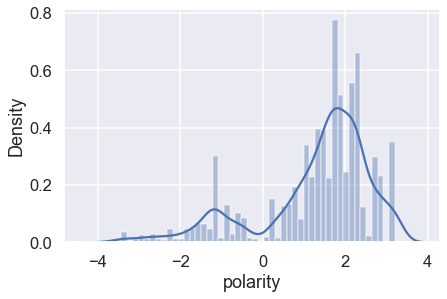

In [7]:
# Display the distribution of polarity scores
sns.distplot(df['polarity'])

C:\Users\yang2\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


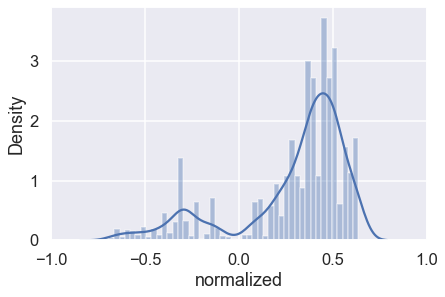

In [8]:
# Display the distribution of normalized polarity scores
df['normalized'] = df['polarity'] / np.sqrt(np.square(df['polarity']) + 15)
sns.distplot(df['normalized'])
plt.xlim(-1, 1);

In [9]:
# The number of normalized polarity scores that are classified as positive (>= 0.05)
len(df.loc[df['normalized'] >= 0.05])

6165

In [10]:
# The number of normalized polarity scores that are classified as negative (<= -0.05)
len(df.loc[df['normalized'] <= -0.05])

1194

In [11]:
# The number of normalized polarity scores that are classified as neutral (>= -0.05 & <= 0.05) 
len(df) - len(df.loc[df['normalized'] <= -0.05]) - len(df.loc[df['normalized'] >= 0.05])

24

In [12]:
# Top 5 most negative subject lines
print('Most negative subject lines:')
for s in df.sort_values('polarity').head()['subject']:
    print('\n  ', s)

Most negative subject lines:

   take 10% off through sunday!

   haven't added a payment method yet? here's why you should.

   student at martin luther king jr. freedom center and 9 more jobs in berkeley, ca for you. apply now.

   lowkey nights are lowkey boring. tame impala \\ billie eilish \\ rage against the machine are coming to sf bay area.

   acrobat dc makes collaborating easy


In [13]:
# Top 5 most positive subject lines
print('Most positive subject lines:')
for s in df.sort_values('polarity', ascending=False).head()['subject']:
    print('\n  ', s)

Most positive subject lines:

   designer favorites on sale

   purchase your haas @ home package!

   save now, travel later with unsold.com

   your postman weekly summary for november 17 - november 23

   problem 3, part b
